##**Theoretical Framework for Bayesian Inference of ($ H_0 $) and ($ \Omega_m $)**

The Hubble constant ($ H_0 $) and the matter density parameter ($ \Omega_m $) are fundamental cosmological parameters that describe the expansion rate of the universe and the relative contribution of matter to its energy density. Using observational data, we can infer these parameters through a combination of theoretical models and Bayesian statistical methods.

###Luminosity Distance and Redshift Relation :
In the standard $\Lambda$CDM cosmology, the luminosity distance ($ D_L(z) $) is given by:

\begin{equation}
D_L(z) = (1+z) \frac{c}{H_0} \int_0^z \frac{dz'}{E(z')}
\end{equation}

where:
* ($ c $) is the speed of light,
* ($ H_0 $) is the Hubble constant,
* $( E(z) = \frac{H(z)}{H_0} )$ is the dimensionless Hubble parameter.

For a flat universe dominated by matter and dark energy, the Hubble parameter takes the form:

\begin{equation}
E(z) = \sqrt{\Omega_m (1+z)^3 + \Omega_\Lambda}
\end{equation}

where ($ \Omega_m $) is the matter density parameter and ($ \Omega_\Lambda $) represents the dark energy contribution.

###Bayesian Inference for ($ H_0 $) and ($ \Omega_m $) :
Bayesian inference provides a probabilistic framework for estimating cosmological parameters. Given observational data $( D )$, Bayes' theorem states:

\begin{equation}
P(H_0, \Omega_m | D) = \frac{P(D | H_0, \Omega_m) P(H_0, \Omega_m)}{P(D)}.
\end{equation}

Here:


* $( P(H_0, \Omega_m | D) )$ is the posterior probability distribution of the parameters given the data,

* $( P(D | H_0, \Omega_m) )$ is the likelihood function describing how well the parameters fit the data,

* $( P(H_0, \Omega_m) )$ is the prior distribution encoding prior knowledge,

* $( P(D) )$ is the evidence, a normalization factor.

The likelihood function for luminosity distance data is modeled as a Gaussian:

\begin{equation}
\mathcal{L}(H_0, \Omega_m) = \prod_{i} \frac{1}{\sqrt{2\pi\sigma_i^2}} \exp \left(-\frac{D_{L,i}^{\text{obs}} - D_L(z_i; H_0, \Omega_m)^2}{2\sigma_i^2} \right),
\end{equation}

where ($ \sigma_i $) represents the observational uncertainty.

###Final Parameter Estimation and Uncertainty Analysis :
Once MCMC sampling is complete, we extract parameter estimates from the posterior distributions:

* The best-fit values correspond to the maximum a posteriori (MAP) estimates.

* Confidence intervals are derived from the marginalized distributions of $( H_0 $) and $( \Omega_m $).

These results provide constraints on the expansion history of the universe and the matter content, allowing us to assess the consistency of the \(\Lambda\)CDM model with observational data.



In [1]:
#INSTALL REQUIRED PACKAGES
!pip install corner

In [2]:
#IMPORTING LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import astropy.constants as cons
import astropy.units as unit
from astropy.cosmology import FlatLambdaCDM
import scipy.integrate as spi
import pytensor.tensor as pt
import pytensor
import pytensor.tensor.extra_ops as pte
import corner


In [3]:
#FUNCTION FOR INTEGRAND
def Ez(z, Om):
    return  pt.sqrt(Om * (1 + z)**3 + (1 - Om))
#FUNCTION FOR TRAPEZOIDAL
def dCs(zs, Om):
    dz = zs[1:] - zs[:-1]
    fz = 1 / Ez(zs, Om)
    I = 0.5 * dz * (fz[:-1] + fz[1:])
    return pt.concatenate([pt.zeros_like(I[:1]), pt.extra_ops.cumsum(I)])
#FUNCTION FOR THE INTEGRAL
def dLs(zs, dCs):
    return dCs * (1 + zs)
#FUNCTION FOR INTERPOLATION
def interp(x, xs, ys):
    x = pt.as_tensor(x)
    xs = pt.as_tensor(xs)
    ys = pt.as_tensor(ys)
    ind = pte.searchsorted(xs, x)
    r = (x - xs[ind-1])/(xs[ind]-xs[ind-1])
    return r*ys[ind] + (1-r)*ys[ind-1]

In [4]:
#VARIABLES
c = cons.c.to(unit.km / unit.s).value    # Speed of light in km/s
H0_true = 70.0                           # True Hubble constant
Om_true = 0.3                            # True matter density parameter
cosmo = FlatLambdaCDM(H0=H0_true, Om0=Om_true)
noise = 0.01                             # Noise for Luminousity Distance

In [5]:
#SYNTHETIC DATA GENERATION
N = 10000                                                  # Number of data points
zt = np.sort(np.random.uniform(0.01, 0.1, N))              # Redshift
DL_true = cosmo.luminosity_distance(zt).to(unit.Mpc).value # True Luminousity Distance in Mpc
DL_observed = np.random.normal(DL_true, noise)             # Observed Luminousity Distance (noisy)


In [6]:
#PRE MODEL
zmax=100 # Maximum redshift for the interpolated cosmology grid.
Nz=1024  # Number of points in redshift grid (uniformly distributed in `log(1+z)`).
zinterp = np.expm1(np.linspace(0, np.log1p(np.max(zt)), 1024))

In [7]:
#PYMC MODEL
with pm.Model() as model:
    H0 = pm.Uniform('H0', lower=50, upper=100, initval=70)
    Om = pm.Uniform('Om', lower=0.1, upper=0.5, initval=0.3)
    dCinterp = (c / H0) * dCs(zinterp, Om)
    dLinterp = dLs(zinterp, dCinterp)
    dL = interp(zt, zinterp, dLinterp)
    y_obs = pm.Normal('dL_likelihood', mu=dL, sigma=noise, observed=DL_observed)
    trace = pm.sample(2000, tune=1000, target_accept=0.98)

Output()

In [8]:
#POSTERIOR EXTRACTION
H0_samples = trace.posterior['H0'].values.flatten()
Om_samples = trace.posterior['Om'].values.flatten()
H0_post = np.mean(H0_samples)
Om_post = np.mean(Om_samples)

In [9]:
#ESTIMATED PARAMETERS
print(f"Estimated H0: {H0_post:.4f} km/s/Mpc")
print(f"Estimated Om: {Om_post:.4f}")

Estimated H0: 69.9999 km/s/Mpc
Estimated Om: 0.3000


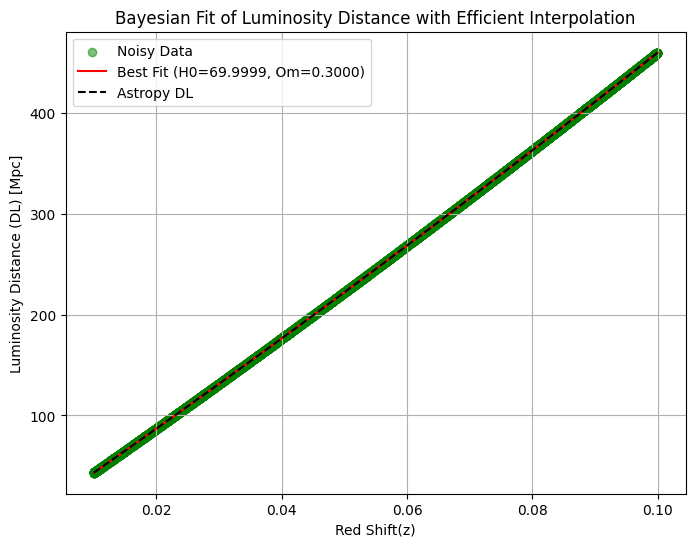

In [10]:
#PLOTTING DL vs Z
plt.figure(figsize=(8, 6))
plt.scatter(zt, DL_observed, label='Noisy Data', color='green', alpha=0.5)
plt.plot(zt, FlatLambdaCDM(H0=H0_post, Om0=Om_post).luminosity_distance(zt).to(unit.Mpc).value, label=f'Best Fit (H0={H0_post:.4f}, Om={Om_post:.4f})', color='red')
plt.plot(zt, DL_true, label='Astropy DL', color='black', linestyle='dashed')
plt.xlabel('Red Shift(z)')
plt.ylabel('Luminosity Distance (DL) [Mpc]')
plt.title('Bayesian Fit of Luminosity Distance with Efficient Interpolation')
plt.legend()
plt.grid()
plt.show()

0.00010088758233890323

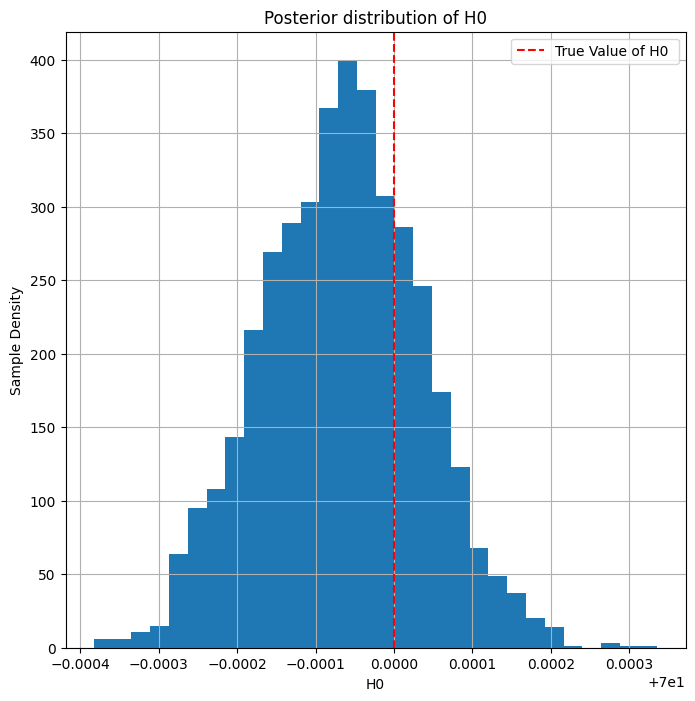

In [11]:
#POSTERIOR DISTRIBUTION OF H0
plt.figure(figsize=(8,8))
plt.hist(H0_samples, bins = 30);# x- axis H0 , y-axis samples

plt.axvline(H0_true, color = 'r', linestyle='dashed', label= "True Value of H0 ")#true value = 70
plt.title("Posterior distribution of H0")
plt.xlabel("H0")
plt.ylabel("Sample Density")
plt.grid(visible=True)
plt.legend()

np.std(H0_samples) # error bar for H0 || Posterior is covered by the whole sample. Sample covers all the moments.

2.4578065094028404e-05

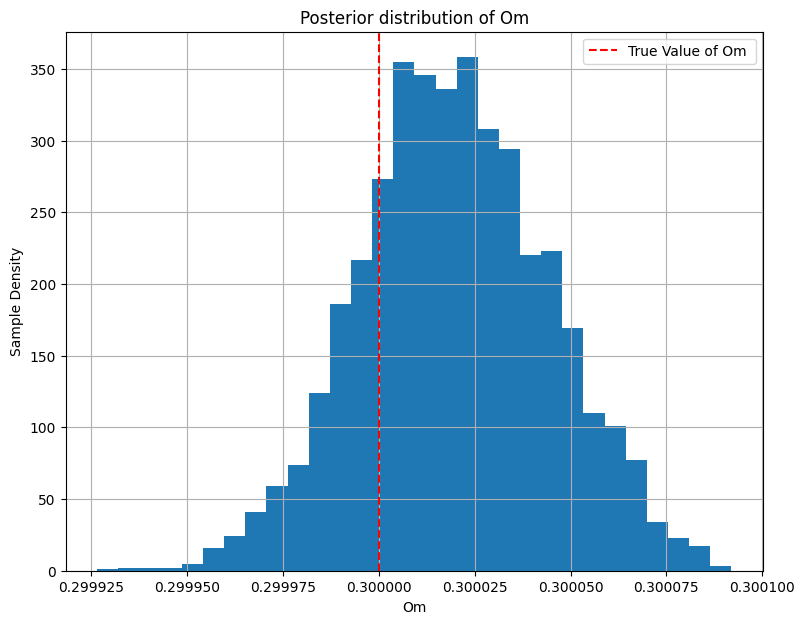

In [12]:
#POSTERIOR DISTRIBUTION OF OM
plt.figure(figsize=(9,7))
plt.hist(Om_samples, bins = 30);# x- axis Om , y-axis samples

plt.axvline(Om_true, color = 'r', linestyle='dashed', label= "True Value of Om ")#true value = 0.3
plt.title("Posterior distribution of Om")
plt.xlabel("Om")
plt.ylabel("Sample Density")
plt.grid(visible=True)
plt.legend()

np.std(Om_samples) # error bar for Om || Posterior is covered by the whole sample. Sample covers all the moments.

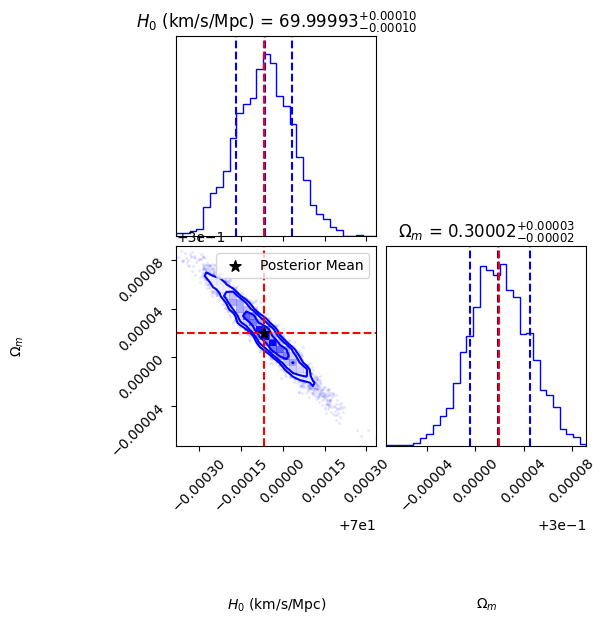

In [13]:
#CORNER PLOT FOR H0 vs OM
import corner

# Stack the samples into a single array
samples = np.vstack((H0_samples, Om_samples)).T

# Define labels for the parameters
labels = [r"$H_0$ (km/s/Mpc)", r"$\Omega_m$"]

# Create the corner plot
fig = corner.corner(samples, labels=labels, show_titles=True, quantiles=[0.16, 0.5, 0.84],title_fmt=".5f", bins=30, color="blue",labelpad=0.45,plot_contours=True)

# Extract axes from the figure; for 2 parameters, shape is (2,2)
axes = np.array(fig.axes).reshape((2, 2))

# Posterior means
H0_mean = np.mean(H0_samples)
Om_mean = np.mean(Om_samples)

# Add vertical lines on the 1D histograms at the mean values:
axes[0, 0].axvline(H0_mean, color="red", linestyle="--")
axes[1, 1].axvline(Om_mean, color="red", linestyle="--")
axes[1, 0].axvline(H0_mean, color="red", linestyle="--")
axes[1, 0].axhline(Om_mean, color="red", linestyle="--")

# Mark the posterior mean on the 2D contour plot (lower left panel)
axes[1, 0].scatter(H0_mean, Om_mean, color="black", marker="*", s=70, label="Posterior Mean", zorder = 5)
axes[1, 0].legend(loc="upper right")

plt.show()


#Using Taylor Expansion to compare $H_0$ and $\Omega_m$ for all orders of redshift ($z$)

##Polynomial Approximation from the Integral and Taylor Expansion in Cosmology :
###1. Derivation of the Polynomial from the Integral :

The luminosity distance \( D_L(z) \) in an expanding universe is given by:

\begin{equation}
    D_L(z) = (1+z) \int_0^z \frac{c \, dz'}{H(z')}
\end{equation}

where ($ H(z) $) is the Hubble parameter, defined in terms of the matter density parameter ($ \Omega_m $) and the Hubble constant ($ H_0 $) as:

\begin{equation}
    H(z) = H_0 \sqrt{\Omega_m (1+z)^3 + (1 - \Omega_m)}
\end{equation}

Since the integral does not have a simple analytical solution, we approximate it using a Taylor series expansion. We express the integral as a power series in ($ z $), which allows us to approximate the luminosity distance in a polynomial form:

\begin{equation}
    \int_0^z \frac{dz'}{H(z')} \approx \sum_{i=0}^{n} a_i z^i
\end{equation}

where the coefficients ($ a_i $) are determined by expanding ($ H(z) $) in a power series and integrating term by term.

###2. Using the Polynomial for Taylor Expansion :

From the polynomial approximation of the integral, we express ($ D_L(z) $) as a truncated Taylor series:

\begin{equation}
    D_L(z) \approx \sum_{i=1}^{n} b_i z^i
\end{equation}

where ($ b_i $) are coefficients derived from the expansion of the integral.

In our Bayesian inference framework, we use this Taylor expansion to infer ($ H_0 $) and ($ \Omega_m $) by performing a regression with observed luminosity distance data.
\begin{equation}
    D_L = \sum_{i=0}^{n} \left[ \frac{c}{H_0} \sum_{j=0}^{n} P_{ij} \Omega_m^j \frac{z^{i+1}}{(i+1)!} + \frac{c}{H_0} \sum_{j=0}^{n} P_{ij} \Omega_m^j \frac{z^{i+2}}{(i+1)!} - \frac{c}{H_0} \sum_{j=0}^{n} P_{ij} \Omega_m^j \frac{z^{n+1}}{(n+2)!} \right]
\end{equation}


###3.Comparing $H_0$ and $\Omega_m$ Across Different Orders of $z$ :

To analyze the impact of truncating the Taylor series at different orders, we fit the series for increasing values of ($ n $) and compare the inferred values of ($ H_0 $) and ($ \Omega_m $). This is implemented in the Bayesian inference framework, where for each order ($ n $), we generate posterior distributions of ($ H_0 $) and ($ \Omega_m $), visualized using corner plots.

The final comparison is performed by examining the convergence of ($ H_0 $) and ($ \Omega_m $) as ($ n $) increases. This helps assess the validity of the Taylor expansion approximation in modeling cosmological distances.


In [17]:
# Initialize a 20x20 zero matrix
P = np.zeros((51, 51))

# Do not open the region below , it is too big to scroll
#region
P[0, 0] = 1
P[1, 1] = -1.5
P[2, 2] = 27/4
P[2, 1] = -3
P[3, 3] = -405/8
P[3, 2] = 81/2
P[3, 1] = -3
P[4, 4] = 8505/16
P[4, 3] = -1215/2
P[4, 2] = 135
P[5, 5] = -229635/32
P[5, 4] = 42525/4
P[5, 3] = -4050
P[5, 2] = 270
P[6, 6] = 7577955/64
P[6, 5] = -3444525/16
P[6, 4] = 467775/4
P[6, 3] = -18225
P[6, 2] = 270
P[7, 7] = -295540245/128
P[7, 6] = 159137055/32
P[7, 5] = -56260575/16
P[7, 4] = 893025
P[7, 3] = -56700
P[8, 8] = 13299311025/256
P[8, 7] = -2068781715/16
P[8, 6] = 901776645/8
P[8, 5] = -40186125
P[8, 4] = 5060475
P[8, 3] = -113400
P[9, 9] = -678264862275/512
P[9, 8] = 119693799225/32
P[9, 7] = -31031725725/8
P[9, 6] = 7161167475/4
P[9, 5] = -699238575/2
P[9, 4] = 21432600
P[9, 3] = -113400
P[10, 10] = 38661097149675/1024
P[10, 9] = -30521918802375/256
P[10, 8] = 4588262303625/32
P[10, 7] = -651666240225/8
P[10, 6] = 43762690125/2
P[10, 5] = -2387055825
P[10, 4] = 65488500
P[11, 11] = -2435649120429525/2048
P[11, 10] = 2126360343232125/512
P[11, 9] = -1454878129579875/256
P[11, 8] = 15360704233875/4
P[11, 7] = -10581818472225/8
P[11, 6] = 428874363225/2
P[11, 5] = -12819373875
P[11, 4] = 130977000
P[12, 12] = 168059789309637225/4096
P[12, 11] = -80376420974174325/512
P[12, 10] = 61664449953731625/256
P[12, 9] = -3021669961435125/16
P[12, 8] = 1274938451411625/16
P[12, 7] = -17408798131725
P[12, 6] = 1712579940225
P[12, 5] = -53045685000
P[12, 4] = 130977000
P[13, 13] = -12604484198222791875/8192
P[13, 12] = 6554331783075851775/1024
P[13, 11] = -348297824221422075/32
P[13, 10] = 1243920800790793125/128
P[13, 9] = -155671959865046625/32
P[13, 8] = 5391607186090125/4
P[13, 7] = -380148984039825/2
P[13, 6] = 11150733443850
P[13, 5] = -160905244500
P[14, 14] = 1020963220056046141875/16384
P[14, 13] = -1147008062038274060625/4096
P[14, 12] = 535270428951194561625/1024
P[14, 11] = -134094662325247498875/256
P[14, 10] = 38893257038058798375/128
P[14, 9] = -1639647652036519125/16
P[14, 8] = 19103595832195875
P[14, 7] = -1738035238314375
P[14, 6] = 58408603753500
P[14, 5] = -321810489000

P[15, 15] = -88823800144876014343125/32768
P[15, 14] = 107201138105884844896875/8192
P[15, 13] = -108965765893636035759375/4096
P[15, 12] = 7570253209452608800125/256
P[15, 11] = -2499036888788703388125/128
P[15, 10] = 249032944318316783625/32
P[15, 9] = -29109686576010665625/16
P[15, 8] = 460283502368064375/2
P[15, 7] = -13305214441393875
P[15, 6] = 238944288082500
P[15, 5] = -321810489000

P = P.astype(np.float64)  # Ensure matrix P is float64

Performing Bayesian regression with Taylor series truncated at Z^1...


Output()

Bayesian regression summary: 1th order
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
H0taylor  70.404  0.000  70.404   70.404      0.000    0.000    6999.0   
Omtaylor   0.302  0.114   0.125    0.497      0.001    0.001    7362.0   

          ess_tail  r_hat  
H0taylor    6659.0    1.0  
Omtaylor    5410.0    1.0  


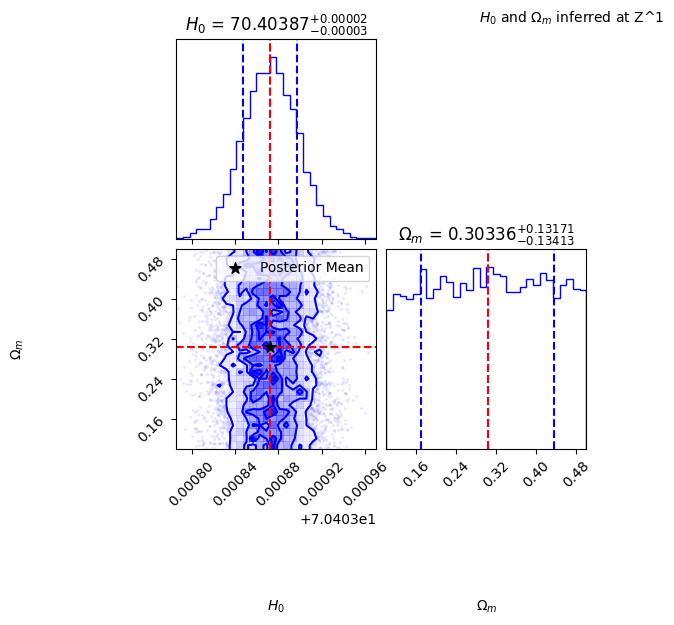

Performing Bayesian regression with Taylor series truncated at Z^2...


Output()

Bayesian regression summary: 2th order
            mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
H0taylor  69.994  0.0  69.994   69.994        0.0      0.0    1991.0   
Omtaylor   0.304  0.0   0.304    0.304        0.0      0.0    1980.0   

          ess_tail  r_hat  
H0taylor    2242.0    1.0  
Omtaylor    2270.0    1.0  


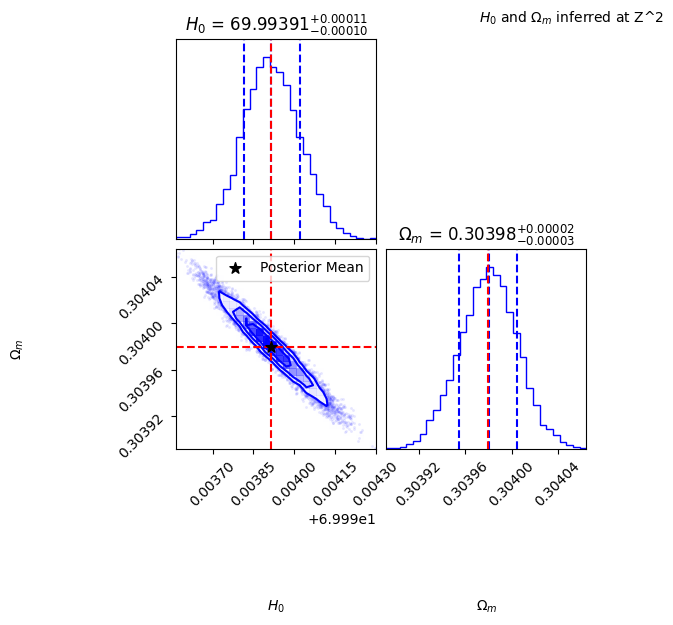

Performing Bayesian regression with Taylor series truncated at Z^3...


Output()

Bayesian regression summary: 3th order
            mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
H0taylor  70.002  0.0  70.002   70.003        0.0      0.0    1829.0   
Omtaylor   0.299  0.0   0.299    0.299        0.0      0.0    1844.0   

          ess_tail  r_hat  
H0taylor    1925.0    1.0  
Omtaylor    1913.0    1.0  


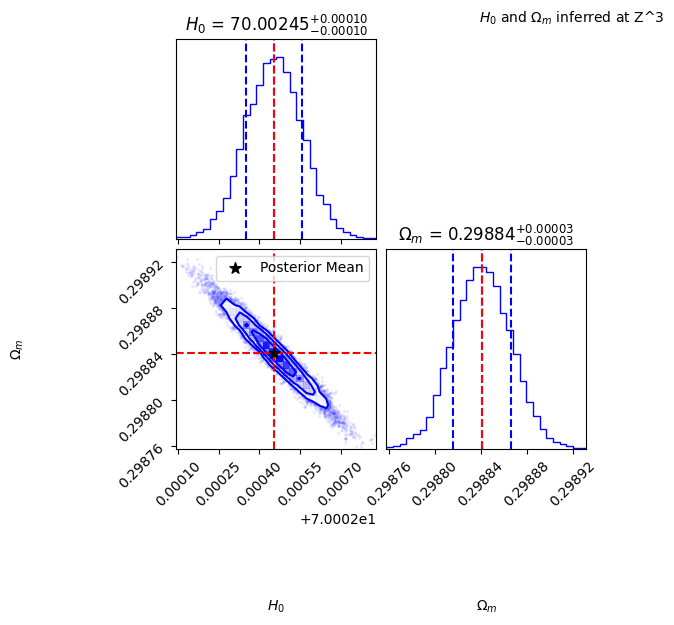

Performing Bayesian regression with Taylor series truncated at Z^4...


Output()

Bayesian regression summary: 4th order
          mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
H0taylor  70.0  0.0    70.0     70.0        0.0      0.0    1915.0    1978.0   
Omtaylor   0.3  0.0     0.3      0.3        0.0      0.0    1934.0    2176.0   

          r_hat  
H0taylor    1.0  
Omtaylor    1.0  


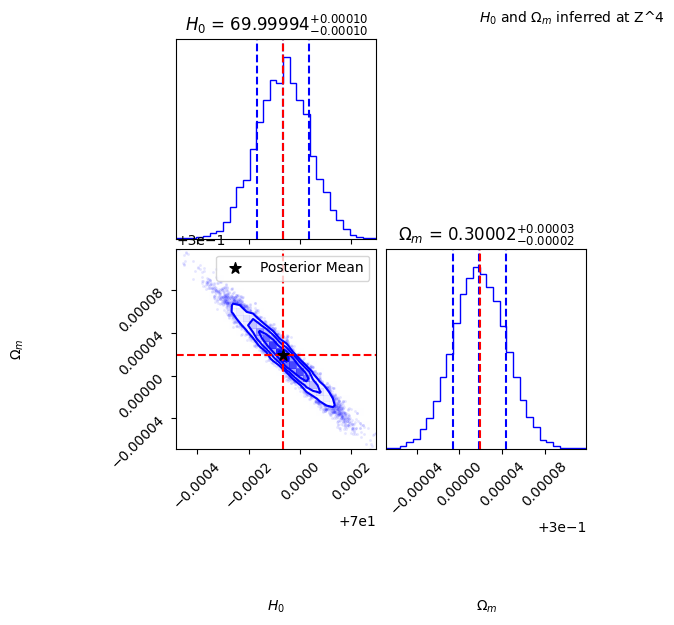

Performing Bayesian regression with Taylor series truncated at Z^5...


Output()

Bayesian regression summary: 5th order
          mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
H0taylor  70.0  0.0    70.0     70.0        0.0      0.0    1985.0    1947.0   
Omtaylor   0.3  0.0     0.3      0.3        0.0      0.0    1940.0    2040.0   

          r_hat  
H0taylor    1.0  
Omtaylor    1.0  


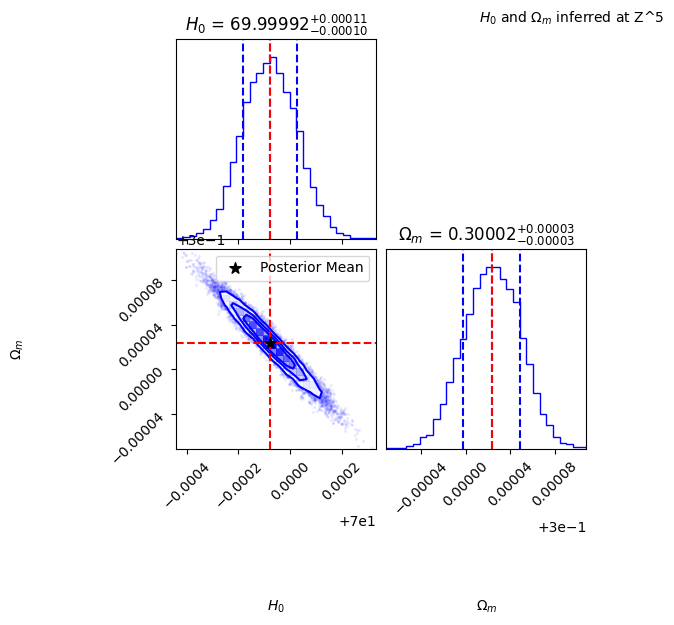

Performing Bayesian regression with Taylor series truncated at Z^6...


Output()

Bayesian regression summary: 6th order
          mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
H0taylor  70.0  0.0    70.0     70.0        0.0      0.0    2125.0    2347.0   
Omtaylor   0.3  0.0     0.3      0.3        0.0      0.0    2122.0    2348.0   

          r_hat  
H0taylor    1.0  
Omtaylor    1.0  


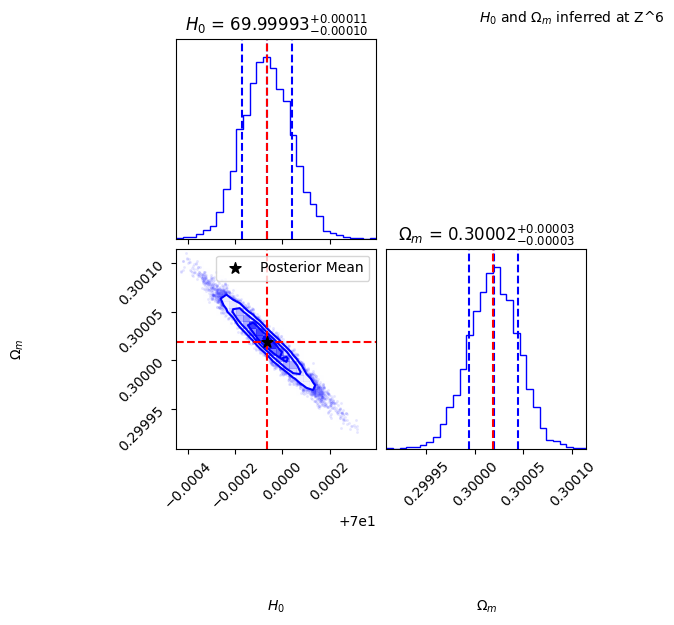

Performing Bayesian regression with Taylor series truncated at Z^7...


Output()

Bayesian regression summary: 7th order
          mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
H0taylor  70.0  0.0    70.0     70.0        0.0      0.0    2195.0    2064.0   
Omtaylor   0.3  0.0     0.3      0.3        0.0      0.0    2175.0    1984.0   

          r_hat  
H0taylor    1.0  
Omtaylor    1.0  


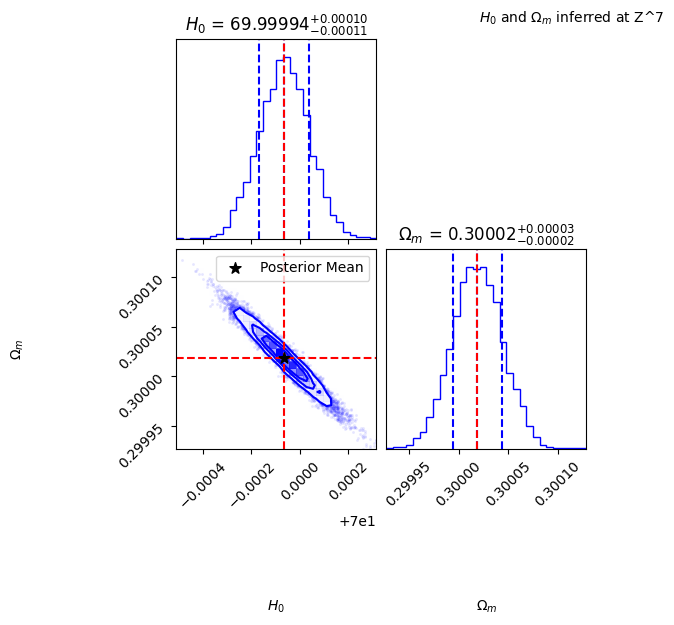

Performing Bayesian regression with Taylor series truncated at Z^8...


Output()

Bayesian regression summary: 8th order
          mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
H0taylor  70.0  0.0    70.0     70.0        0.0      0.0    1788.0    2100.0   
Omtaylor   0.3  0.0     0.3      0.3        0.0      0.0    1790.0    2032.0   

          r_hat  
H0taylor    1.0  
Omtaylor    1.0  


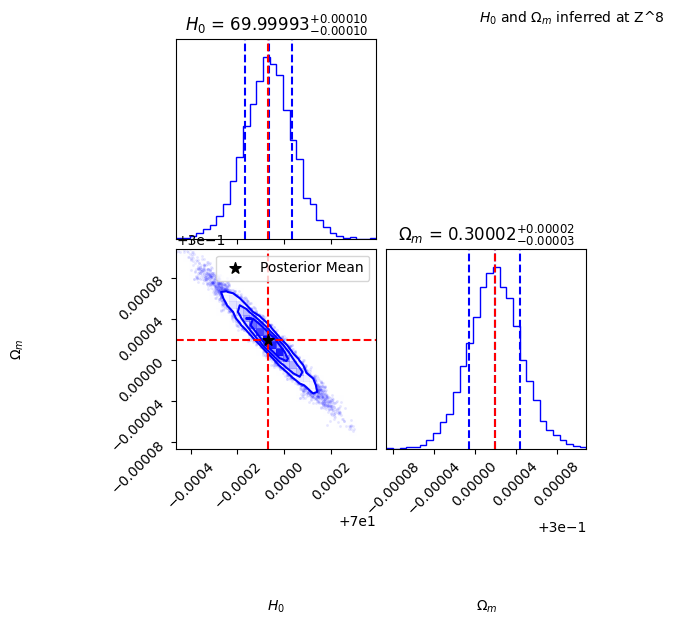

Performing Bayesian regression with Taylor series truncated at Z^9...


Output()

Bayesian regression summary: 9th order
          mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
H0taylor  70.0  0.0    70.0     70.0        0.0      0.0    1859.0    2081.0   
Omtaylor   0.3  0.0     0.3      0.3        0.0      0.0    1855.0    2163.0   

          r_hat  
H0taylor    1.0  
Omtaylor    1.0  


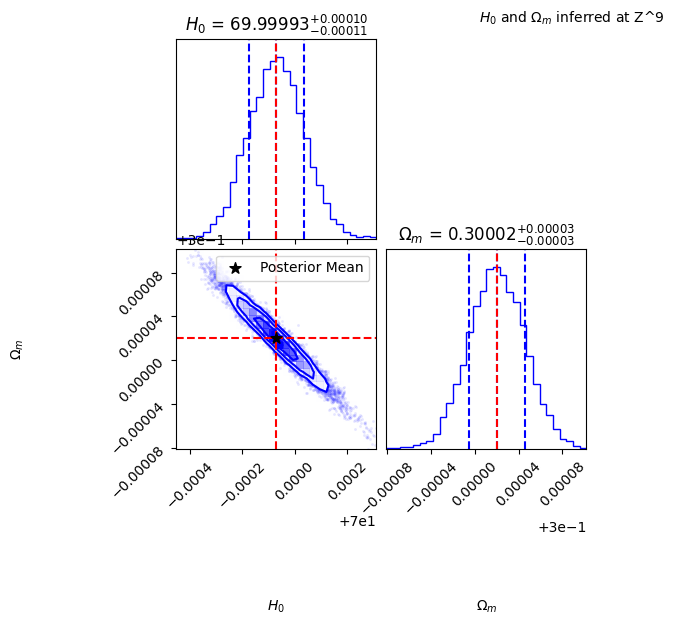

In [20]:
from scipy.special import factorial as fac
import pymc as pm
import numpy as np
import arviz as az
import corner
import matplotlib.pyplot as plt

# Perform Bayesian regression using a Taylor series expansion.
def bayesian_fit(x, y, n, P, c=299792.458):

    with pm.Model() as model:
        H0taylor = pm.Uniform('H0taylor', upper = 100, lower = 50, initval = 70)
        Omtaylor = pm.Uniform('Omtaylor', upper = 0.5, lower = 0.1, initval = 0.3)

        func = 0  # Initialize sum
        for i in range(n):
            temp = 0.0
            for j in range(n):
                temp = sum(P[i, j] * Omtaylor**j for j in range(n))
            func += ((c / H0taylor) * temp * x**(i+1) / fac(i+1)) + ((c / H0taylor) * temp * x**(i+2) / fac(i+1))
            func -= ((c / H0taylor) * temp * x**(n+1) / fac(n+2))

        Y_obs = pm.Normal("Y_obs", mu=func, sigma=noise, observed=y)
        trace = pm.sample(3000,tune=1000, target_accept = 0.98, return_inferencedata=True, cores=4)

    return trace

# Generating corner plots
def cornerH0Om(no, zobs, Dlobs, P):

    print(f"Performing Bayesian regression with Taylor series truncated at Z^{no}...")
    tr = bayesian_fit(zobs, Dlobs, no, P)  # Perform Bayesian fit
    summary = az.summary(tr)
    print(f"Bayesian regression summary: {no}th order")
    print(summary)

    # Extract samples
    samples = np.vstack([tr.posterior["H0taylor"].values.flatten(), tr.posterior["Omtaylor"].values.flatten()]).T
    H0taylor_mean = tr.posterior["H0taylor"].mean().values
    Omtaylor_mean = tr.posterior["Omtaylor"].mean().values

    # Generate corner plot
    fig = corner.corner(samples, labels=["$H_0$", "$\\Omega_m$"], show_titles=True, quantiles=[0.16, 0.5, 0.84],title_fmt=".5f", bins=30, color="blue",labelpad=0.45,plot_contours=True)
    fig.suptitle(f"$H_0$ and $\\Omega_m$ inferred at Z^{no}", fontsize=10, x=0.9)
    axes = np.array(fig.axes).reshape((2, 2))

    # Add vertical lines on the 1D histograms at the mean values:
    axes[0, 0].axvline(H0taylor_mean, color="red", linestyle="--")
    axes[1, 1].axvline(Omtaylor_mean, color="red", linestyle="--")
    axes[1, 0].axvline(H0taylor_mean, color="red", linestyle="--")
    axes[1, 0].axhline(Omtaylor_mean, color="red", linestyle="--")

    # Mark the posterior mean on the 2D contour plot (lower left panel)
    axes[1, 0].scatter(H0taylor_mean, Omtaylor_mean, color="black", marker="*", s=70, label="Posterior Mean", zorder = 5)
    axes[1, 0].legend(loc="upper right")
    plt.show()
    plt.close(fig)

for i in range (1,10):
    cornerH0Om(i, zt, DL_observed, P)
